In [1]:
import logging

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader

from dal_toolbox import metrics
from dal_toolbox.active_learning import ActiveLearningDataModule
from dal_toolbox.active_learning.strategies import xpal
from dal_toolbox.datasets.utils import ContrastiveTransformations
from dal_toolbox.models.deterministic import simclr
from dal_toolbox.models.deterministic.simclr import InfoNCELoss
from dal_toolbox.models.parzen_window_classifier import PWCLightning
from dal_toolbox.models.utils.lr_scheduler import CosineAnnealingLRLinearWarmup
from dal_toolbox.utils import _calculate_mean_gamma, kernels

# configure logging at the root level of Lightning
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

In [2]:
# Settings
seed = 42
moon_noise = 0.07
transforms_noise = moon_noise / 5

# Building SIMCLR model
train_batch_size = 64
learning_rate = 0.01
weight_decay = 0.0
n_epochs = 20
temperature = 0.1
encoder = nn.Sequential(nn.Linear(2, 8), nn.ReLU(), nn.Linear(8, 16), nn.ReLU(),)
projector = nn.Sequential(nn.Linear(16, 4))

# Active learning
n_init = 2
n_query = 1
n_cylce = 13

# Strategy
alpha = 1e-9

L.seed_everything(seed)

Global seed set to 42


42

In [3]:
class GaussianNoiseTransform:
    def __init__(self, mean=0.0, std=1.0, random_seed=0):
        self.rng = np.random.default_rng(random_seed)
        self.mean = mean
        self.std = std

    def __call__(self, x):
        return x + torch.tensor(self.rng.normal(self.mean, self.std, size=x.shape), dtype=torch.float32)


class SKLearnDataset(Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y)
        self.transforms = transforms

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transforms is not None:
            x = self.transforms(x)

        return x, self.y[idx]

In [4]:
@torch.inference_mode()
def get_representations_and_labels(model, dataloader):
    all_features = []
    all_labels = []
    for batch in dataloader:
        features = batch[0]
        labels = batch[1]
        all_features.append(model(features))
        all_labels.append(labels)
    features = torch.cat(all_features)
    labels = torch.cat(all_labels)
    return features, labels

@torch.inference_mode()
def get_representations(model, dataloader):
    all_features = []
    for batch in dataloader:
        features = batch[0]
        all_features.append(model(features))
    features = torch.cat(all_features)
    return features

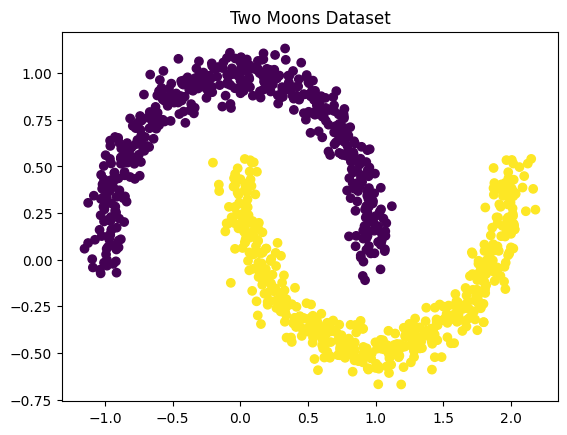

In [5]:
X, y = make_moons(1000, random_state=seed, noise=moon_noise)

plt.scatter(X[:, 0], X[:, 1], c=y, marker="o")
plt.title("Two Moons Dataset")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)

In [6]:
transform = ContrastiveTransformations(GaussianNoiseTransform(std=transforms_noise, random_seed=seed))

trainset = SKLearnDataset(X_train, y_train, transform)
valset = SKLearnDataset(X_val, y_val, transform)
testset = SKLearnDataset(X_test, y_test)

train_dataloader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=train_batch_size, shuffle=False)

In [7]:
optimizer = SGD(params=list(encoder.parameters()) + list(projector.parameters()),
                lr=learning_rate,
                weight_decay=weight_decay)

lr_scheduler = CosineAnnealingLRLinearWarmup(
    optimizer=optimizer,
    num_epochs=n_epochs,
    warmup_epochs=10
)

model = simclr.SimCLR(
    encoder=encoder,
    projector=projector,
    loss_fn=InfoNCELoss(temperature),
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    train_metrics={'train_acc_top1': metrics.ContrastiveAccuracy(),
                   'train_acc_top5': metrics.ContrastiveAccuracy(topk=5)},
    val_metrics={'val_acc_top1': metrics.ContrastiveAccuracy(),
                 'val_acc_top5': metrics.ContrastiveAccuracy(topk=5)}
)
model.encoder_output_dim = 64

trainer = L.Trainer(
    default_root_dir="SIMCLR_Two_Moons",
    accelerator="auto",
    max_epochs=n_epochs,
    check_val_every_n_epoch=4,
    enable_progress_bar=True,
)

In [8]:
trainer.fit(model, train_dataloader, val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

#decision_flips: 20827021


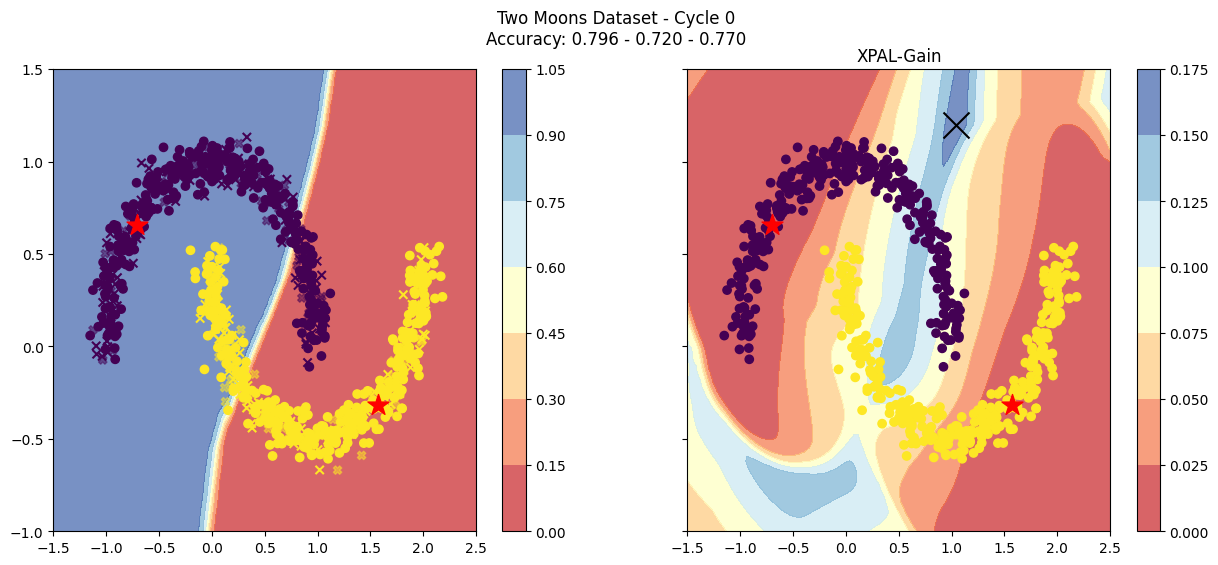

#decision_flips: 116545
#decision_flips: 14726637


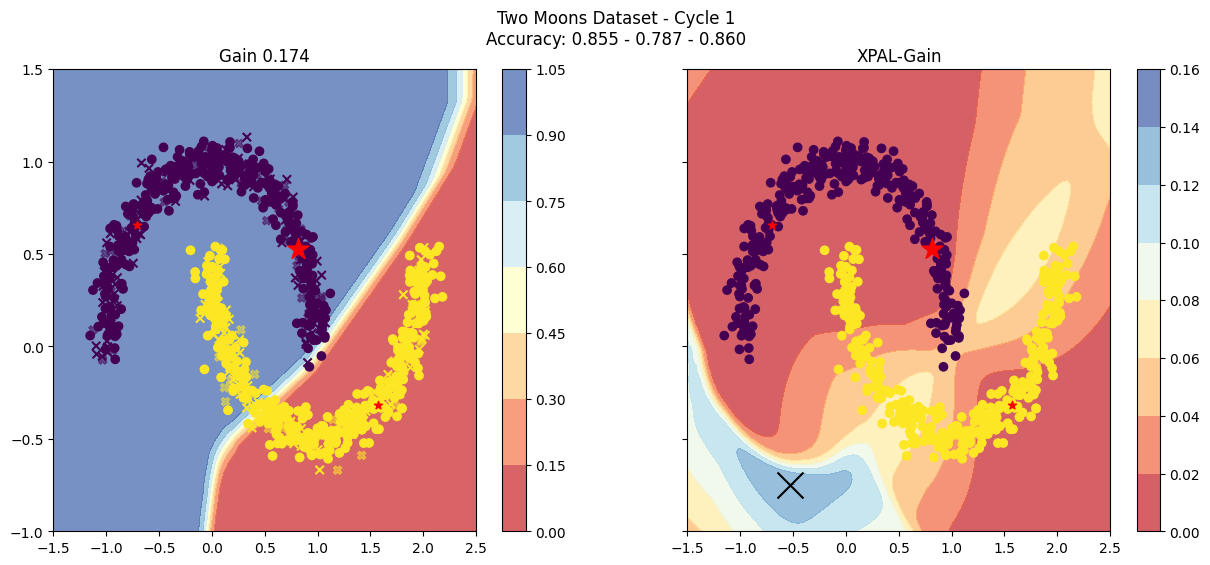

#decision_flips: 71779
#decision_flips: 12321571


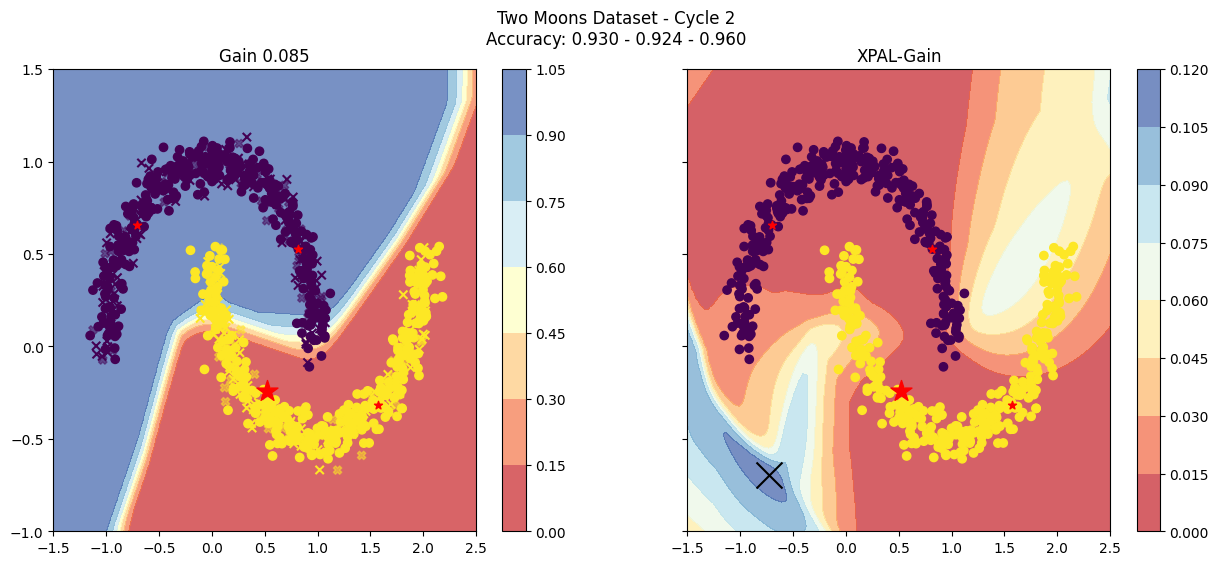

#decision_flips: 55923
#decision_flips: 11617731


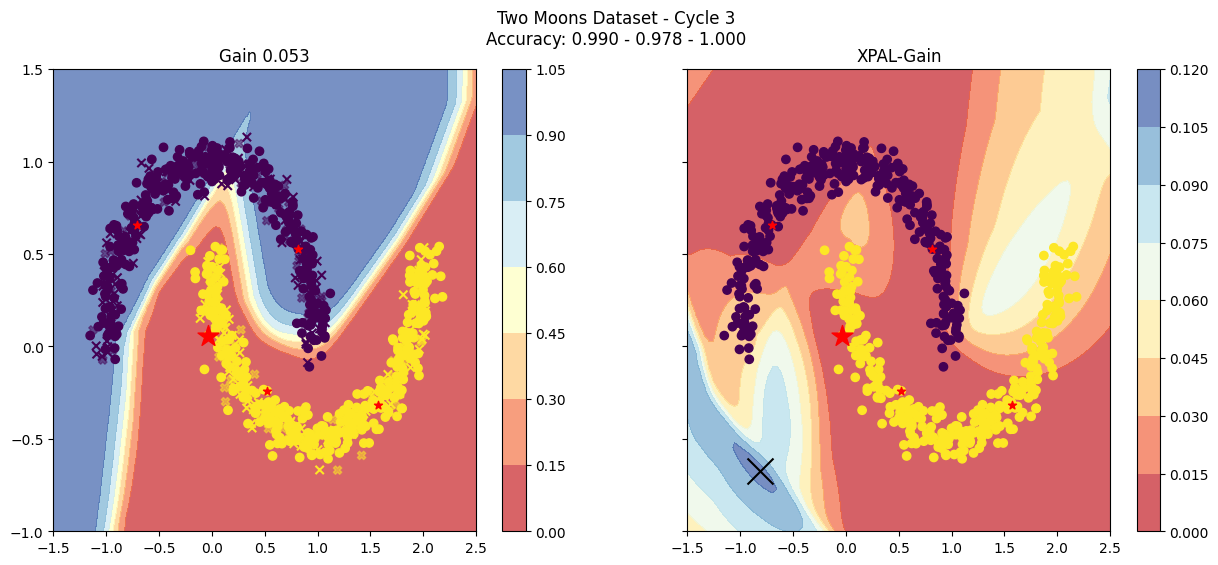

#decision_flips: 47933
#decision_flips: 11114524


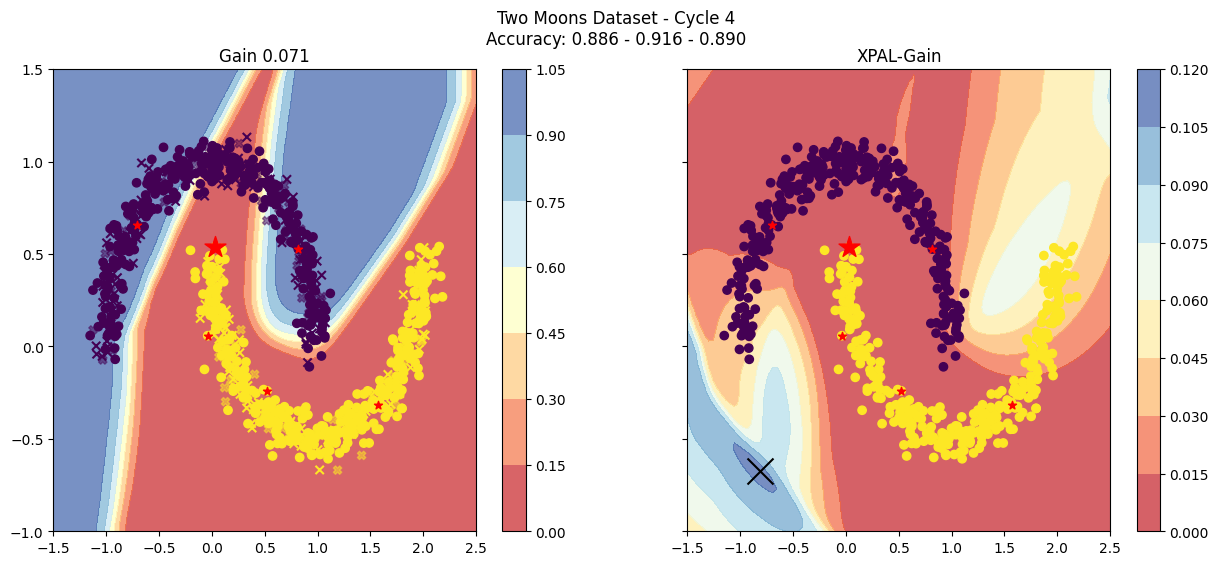

#decision_flips: 40685
#decision_flips: 10956125


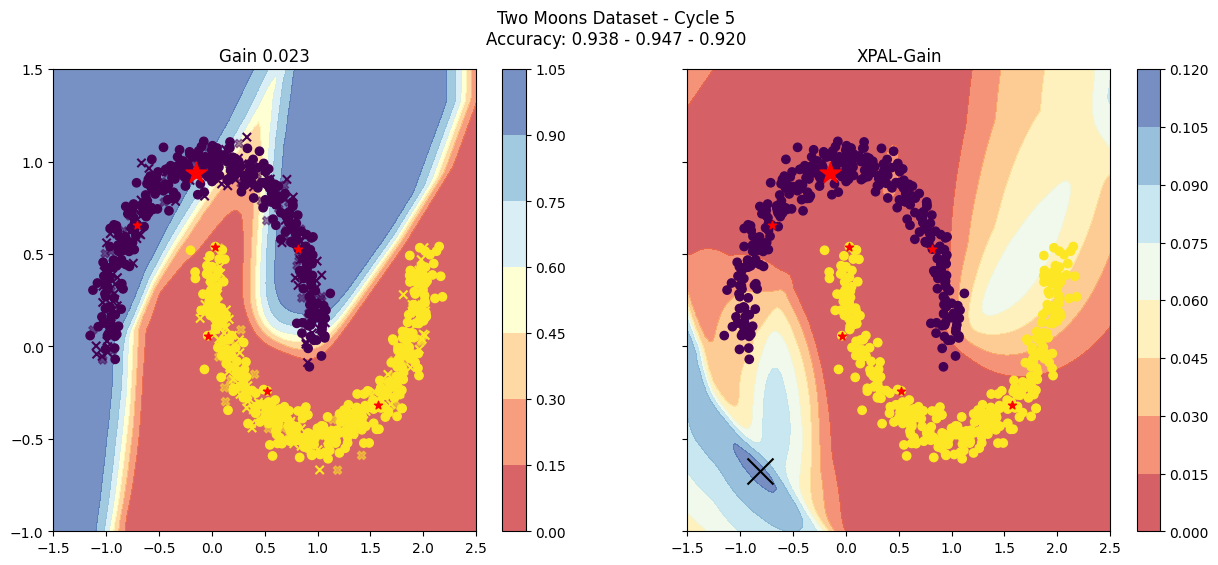

#decision_flips: 35306
#decision_flips: 10586923


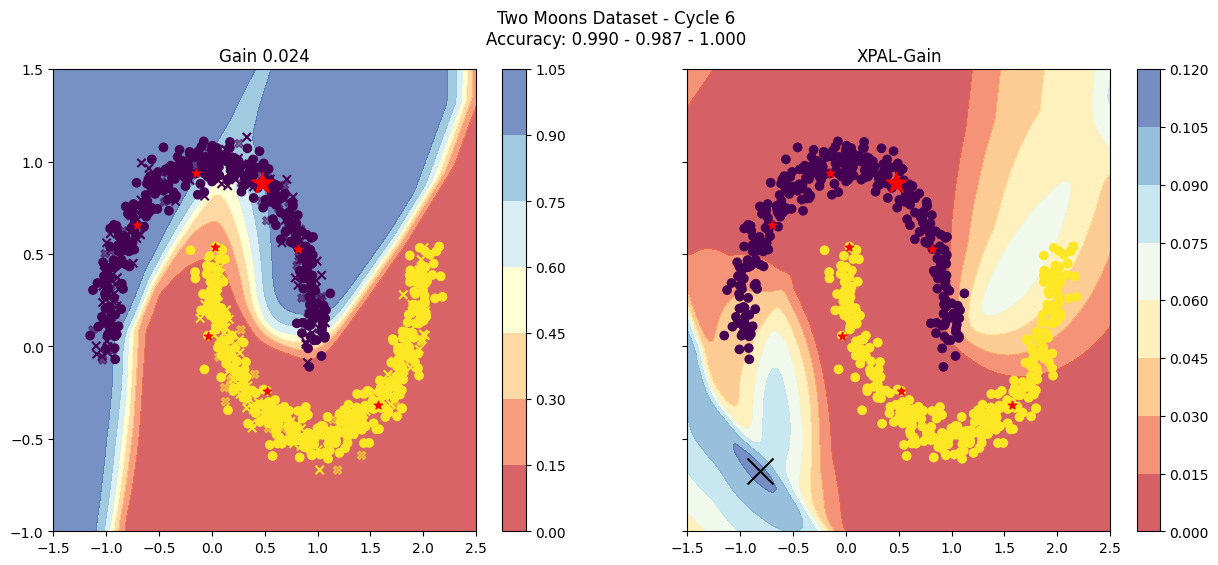

#decision_flips: 29875
#decision_flips: 10416501


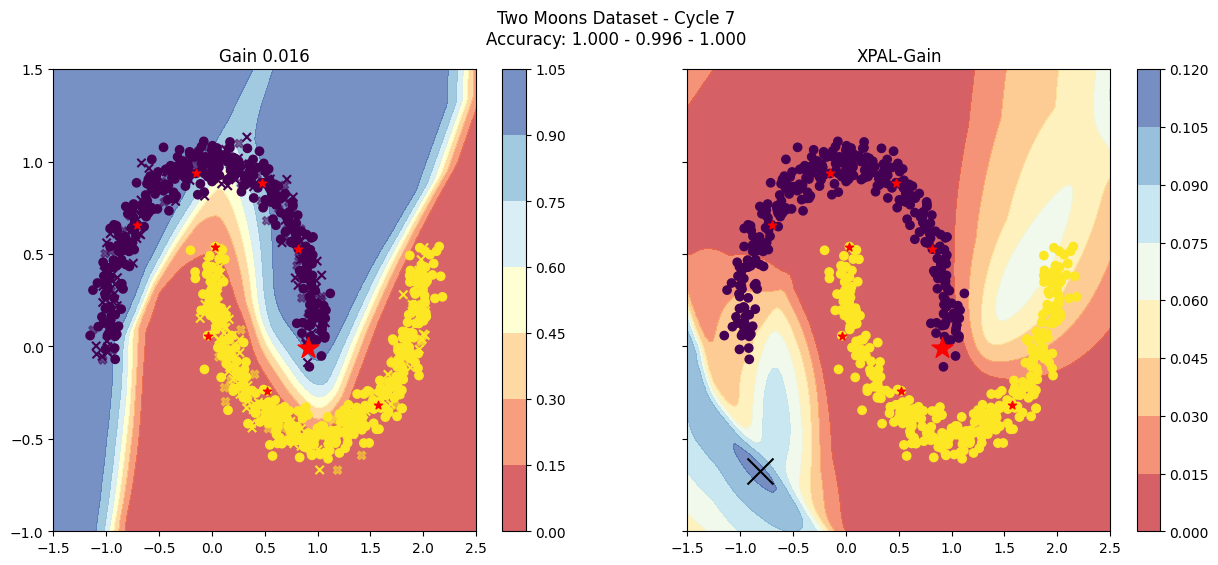

#decision_flips: 27876
#decision_flips: 10237918


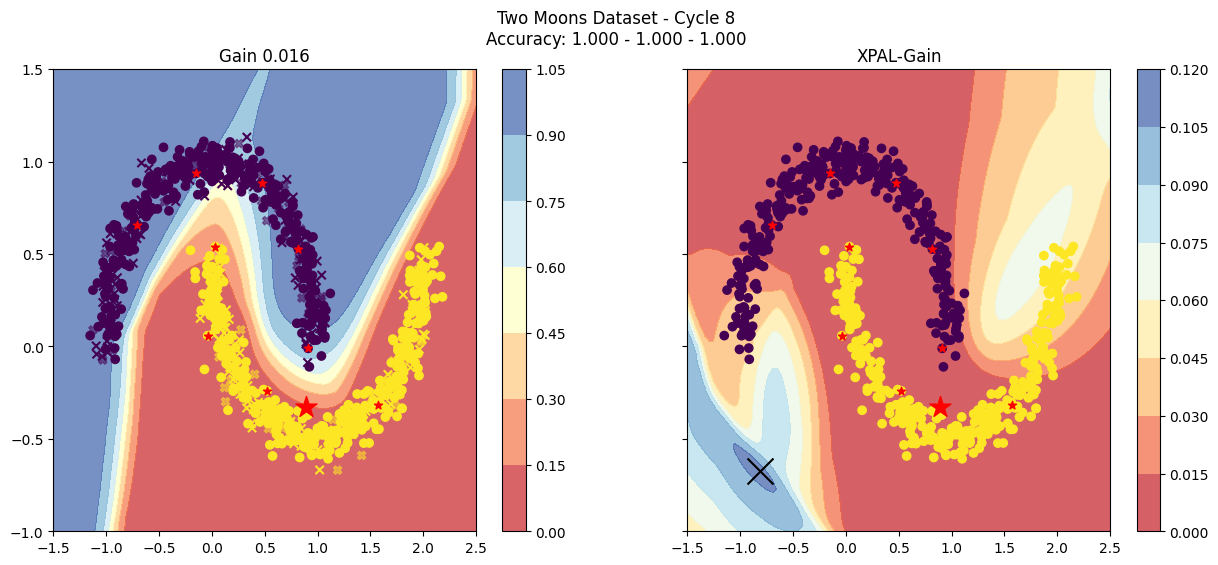

#decision_flips: 22268
#decision_flips: 8064201


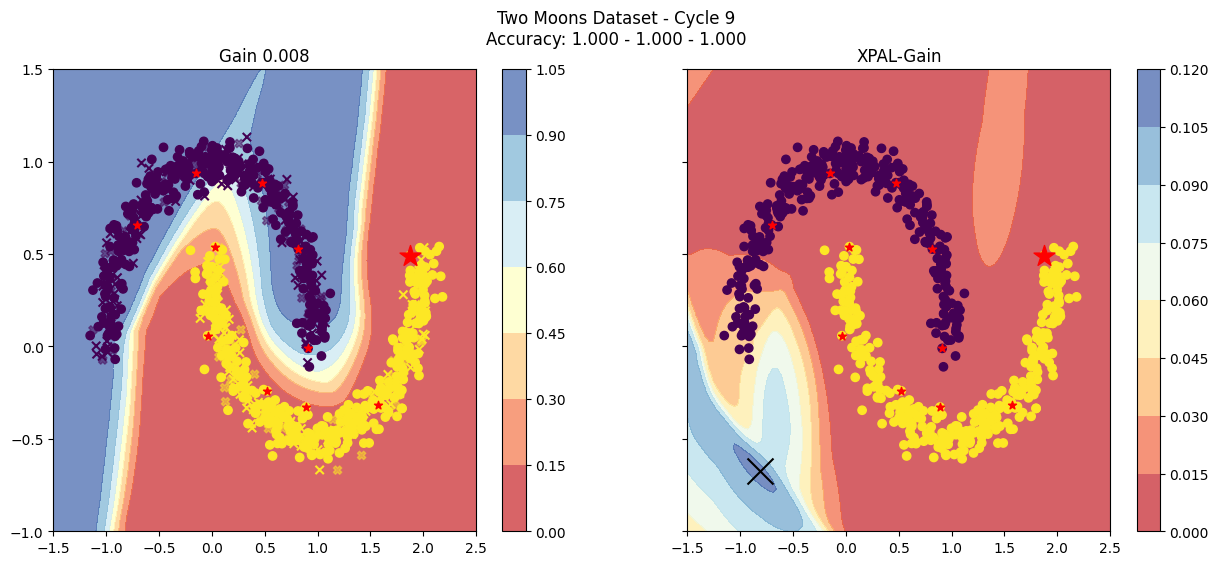

#decision_flips: 18983
#decision_flips: 7970697


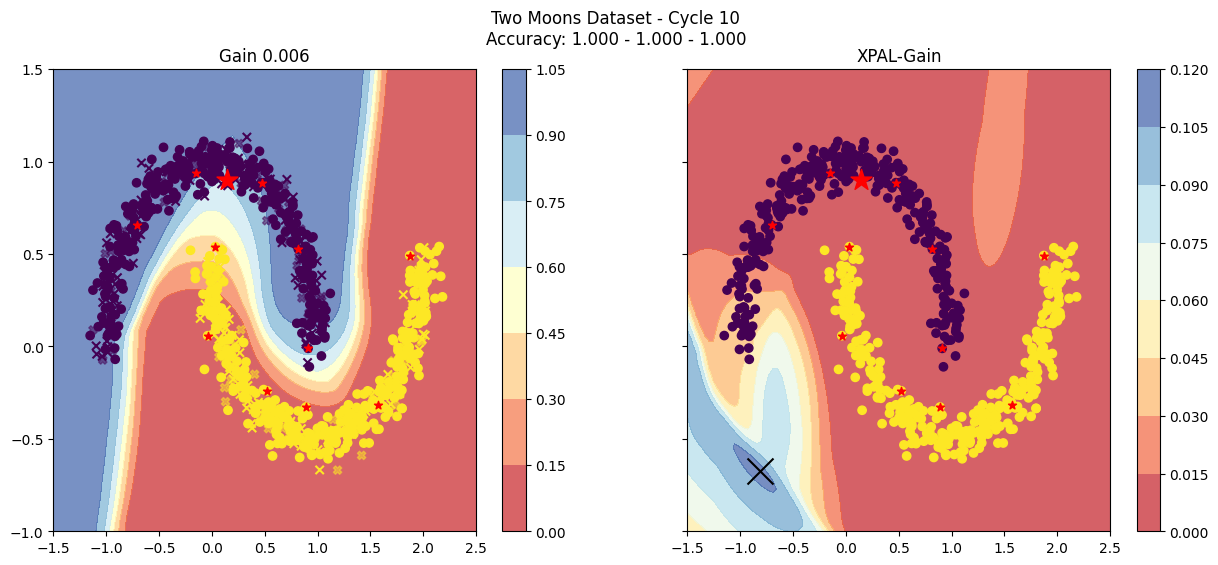

#decision_flips: 16412
#decision_flips: 6024712


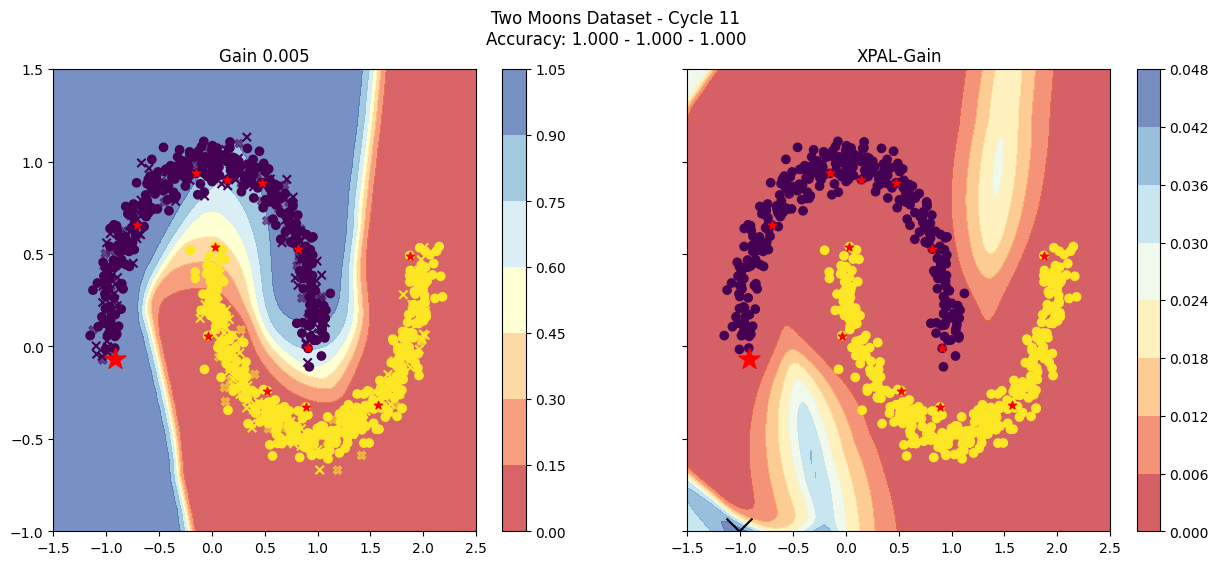

#decision_flips: 14690
#decision_flips: 5973266


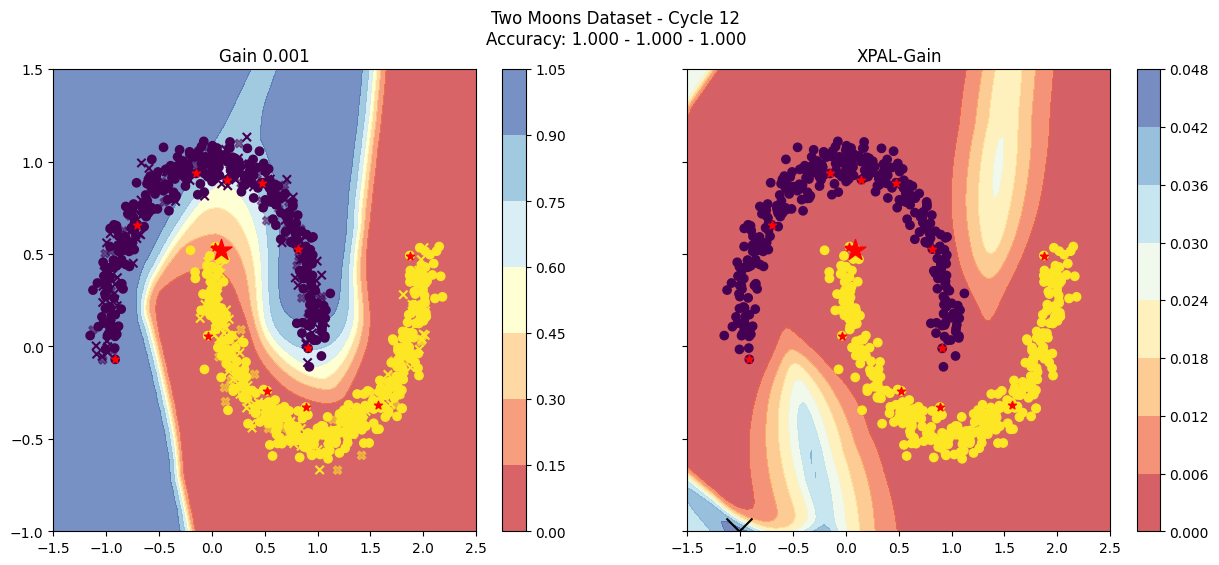

#decision_flips: 14074
#decision_flips: 5826617


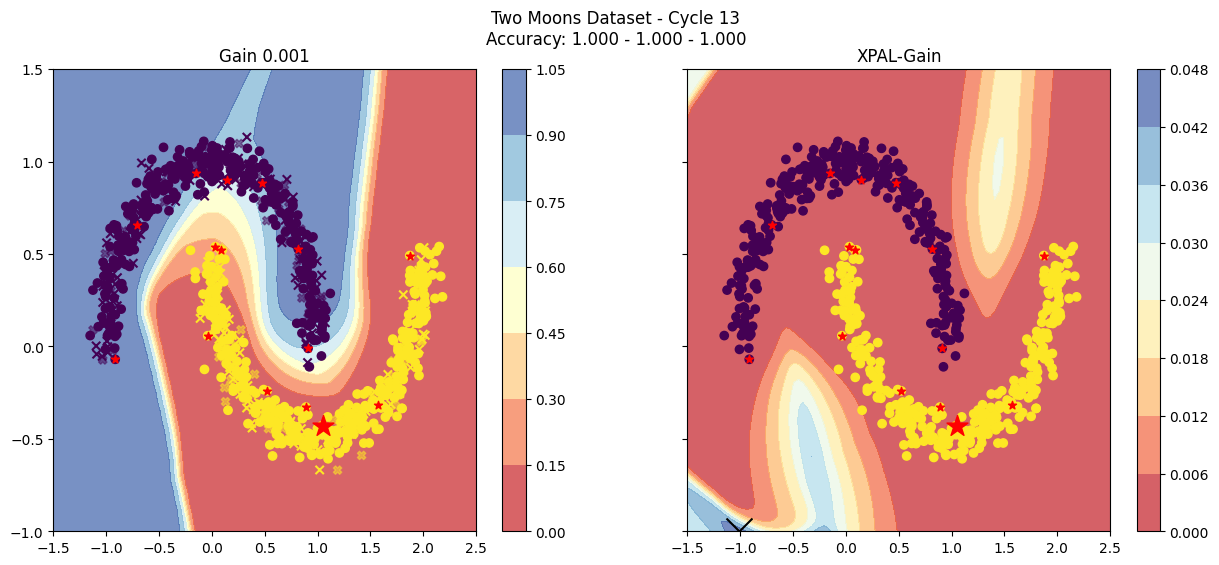

In [10]:
from dal_toolbox.active_learning.strategies.xpal import xpal_gain

standardize = False
grid_size = 100

results = {}
queried_indices = {}

# Get representations while ensuring ability to get representation back
trainset = SKLearnDataset(X_train, y_train)
valset = SKLearnDataset(X_val, y_val)
testset = SKLearnDataset(X_test, y_test)

train_dataloader = DataLoader(trainset, batch_size=512, shuffle=False)
val_dataloader = DataLoader(valset, batch_size=512, shuffle=False)
test_dataloader = DataLoader(testset, batch_size=512, shuffle=False)

train_features, train_labels = get_representations_and_labels(model.encoder, train_dataloader)
val_features, val_labels = get_representations_and_labels(model.encoder, val_dataloader)
test_features, test_labels = get_representations_and_labels(model.encoder, test_dataloader)

if standardize:
    scaler = StandardScaler().fit(train_features)
    train_features = torch.from_numpy(scaler.transform(train_features)).to(dtype=torch.float32)
    val_features = torch.from_numpy(scaler.transform(val_features)).to(dtype=torch.float32)
    test_features = torch.from_numpy(scaler.transform(test_features)).to(dtype=torch.float32)

trainset = SKLearnDataset(train_features, train_labels)
valset = SKLearnDataset(val_features, val_labels)
testset = SKLearnDataset(test_features, test_labels)

# AL Strategy
gamma = _calculate_mean_gamma(train_features)
S = kernels(X=train_features, Y=train_features, metric="rbf", gamma=gamma)
al_strategy = xpal.XPAL(2, S, subset_size=None, alpha_c=alpha, alpha_x=alpha, random_seed=seed)

# AL Model
kernel_params = {"kernel": {"name": "rbf", "gamma": gamma}, "n_neighbors": None}
al_model = PWCLightning(n_classes=2,
                        random_state=seed,
                        kernel_params=kernel_params,
                        train_metrics={'train_acc': metrics.Accuracy()},
                        val_metrics={'val_acc': metrics.Accuracy()})

# Setup AL Module
al_datamodule = ActiveLearningDataModule(
    train_dataset=trainset,
    val_dataset=valset,
    test_dataset=testset,
    train_batch_size=train_batch_size,
    predict_batch_size=512,
    seed=seed
)
al_datamodule.random_init(n_samples=2, class_balanced=True)
queried_indices['cycle0'] = al_datamodule.labeled_indices
top_gains=None

# Active Learning Cycles
for i_acq in range(0, n_cylce + 1):
    cycle_results = {}

    if i_acq != 0:
        indices, top_gains = al_strategy.query(
            model=al_model,
            al_datamodule=al_datamodule,
            acq_size=n_query,
            return_gains=True
        )
        al_datamodule.update_annotations(indices)
        queried_indices[f'cycle{i_acq}'] = indices

    #  model cold start
    al_model.reset_states()

    # Train with updated annotations
    trainer = L.Trainer(
        max_epochs=2,
        enable_checkpointing=False,
        accelerator="cpu",
        default_root_dir="PWC_Two_Moons",
        enable_progress_bar=False,
        check_val_every_n_epoch=1,
    )
    trainer.fit(al_model, al_datamodule)

    # Evaluate resulting model
    loader = DataLoader(al_datamodule.train_dataset)
    predictions = trainer.predict(al_model, loader)
    logits = torch.cat([pred[0] for pred in predictions])
    targets = torch.cat([pred[1] for pred in predictions])

    train_stats = {
        'accuracy': metrics.Accuracy()(logits, targets).item(),
        'nll': torch.nn.CrossEntropyLoss()(logits, targets).item(),
        'brier': metrics.BrierScore()(logits, targets).item(),
        'ece': metrics.ExpectedCalibrationError()(logits, targets).item(),
        'ace': metrics.AdaptiveCalibrationError()(logits, targets).item(),
    }
    train_accuracy = train_stats["accuracy"]

    predictions = trainer.predict(al_model, al_datamodule.val_dataloader())
    logits = torch.cat([pred[0] for pred in predictions])
    targets = torch.cat([pred[1] for pred in predictions])

    val_stats = {
        'accuracy': metrics.Accuracy()(logits, targets).item(),
        'nll': torch.nn.CrossEntropyLoss()(logits, targets).item(),
        'brier': metrics.BrierScore()(logits, targets).item(),
        'ece': metrics.ExpectedCalibrationError()(logits, targets).item(),
        'ace': metrics.AdaptiveCalibrationError()(logits, targets).item(),
    }
    val_accuracy = val_stats["accuracy"]

    predictions = trainer.predict(al_model, al_datamodule.test_dataloader())
    logits = torch.cat([pred[0] for pred in predictions])
    targets = torch.cat([pred[1] for pred in predictions])

    test_stats = {
        'accuracy': metrics.Accuracy()(logits, targets).item(),
        'nll': torch.nn.CrossEntropyLoss()(logits, targets).item(),
        'brier': metrics.BrierScore()(logits, targets).item(),
        'ece': metrics.ExpectedCalibrationError()(logits, targets).item(),
        'ace': metrics.AdaptiveCalibrationError()(logits, targets).item(),
    }
    test_accuracy = test_stats["accuracy"]

    cycle_results.update({
        "test_stats": test_stats,
        "labeled_indices": al_datamodule.labeled_indices,
        "n_labeled_samples": len(al_datamodule.labeled_indices),
        "unlabeled_indices": al_datamodule.unlabeled_indices,
        "n_unlabeled_samples": len(al_datamodule.unlabeled_indices),
    })
    results[f'cycle{i_acq}'] = cycle_results

    ind = queried_indices[f'cycle{i_acq}']
    queried_sample_cycle = X_train[ind]

    queried_samples = X_train[[item for sublist in [value for value in queried_indices.values()] for item in sublist]]

    # Deciscion Boundary
    x_min, x_max = -1.5, 2.5
    y_min, y_max = -1.0, 1.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size), np.linspace(y_min, y_max, grid_size))
    x_in = np.c_[xx.ravel(), yy.ravel()]

    grid_dataset = SKLearnDataset(x_in, np.zeros(x_in.shape[0]))
    grid_dataloader = DataLoader(grid_dataset, batch_size=512, shuffle=False)
    grid_features = get_representations(model.encoder, grid_dataloader)
    if standardize:
        grid_features = torch.from_numpy(scaler.transform(grid_features)).to(dtype=torch.float32)

    y_pred = al_model.model.predict_proba(grid_features)
    y_pred = y_pred[:, 0].reshape(xx.shape)

    # Kinda hacked together
    labeled_loader, labeled_indices = al_datamodule.labeled_dataloader()
    y_labeled = []
    labeled_samples = []
    for batch in labeled_loader:
        y_labeled.append(batch[1])
        labeled_samples.append(batch[0])
    y_labeled = torch.cat(y_labeled).tolist()
    labeled_samples = torch.cat(labeled_samples)

    data = torch.cat([labeled_samples, grid_features])

    S = kernels(data, data, metric="rbf", gamma=gamma)
    alpha = al_strategy.alpha_c_

    mapped_labeled_indices = np.arange(0, len(y_labeled))
    mapped_unlabeled_indices = np.arange(len(y_labeled), len(y_labeled) + grid_features.shape[0])

    Z = np.eye(10)[y_labeled]
    K_x = S[:, mapped_labeled_indices] @ Z
    K_c = K_x[mapped_unlabeled_indices]

    gains = xpal_gain(K_c = K_c, K_x = K_x, S = S[mapped_unlabeled_indices], alpha_c=alpha, alpha_x=alpha)
    gains = gains.reshape(xx.shape)

    max_gain_x_idx , max_gain_y_idx = np.unravel_index(np.argmax(gains), gains.shape)
    max_gain_x , max_gain_y = xx[max_gain_x_idx, max_gain_y_idx], yy[max_gain_x_idx, max_gain_y_idx]

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15, 6))
    fig.suptitle(f"Two Moons Dataset - Cycle {i_acq}\nAccuracy: {train_accuracy:.3f} - {val_accuracy:.3f} - {test_accuracy:.3f}")

    ax1, ax2 = axes[0], axes[1]

    contour = ax1.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    ax1.set_xlim(xx.min(), xx.max())
    ax1.set_ylim(yy.min(), yy.max())

    ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker="o")
    ax1.scatter(X_val[:, 0], X_val[:, 1], c=y_val, marker="x")
    ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker="X", alpha=0.5)
    ax1.scatter(queried_samples[:, 0], queried_samples[:, 1], c="red", marker='*')
    ax1.scatter(queried_sample_cycle[:, 0], queried_sample_cycle[:, 1], c="red", marker='*', s=250)
    ax1.set_title(f"Gain {top_gains.item():.3f}" if top_gains is not None else "")
    fig.colorbar(contour, ax=ax1)


    contour = plt.contourf(xx, yy, gains, cmap=plt.cm.RdYlBu, alpha=0.7)
    # ax2.colorbar(contour)
    ax2.set_xlim(xx.min(), xx.max())
    ax2.set_ylim(yy.min(), yy.max())

    ax2.scatter(max_gain_x, max_gain_y, c="black", s=350, marker="x")
    ax2.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker="o")
    ax2.scatter(queried_samples[:, 0], queried_samples[:, 1], c="red", marker='*')
    ax2.scatter(queried_sample_cycle[:, 0], queried_sample_cycle[:, 1], c="red", marker='*', s=250)
    ax2.set_title(f"XPAL-Gain")
    fig.colorbar(contour, ax=ax2)
    plt.show()